# Descan + STEM Overfocus procedure

Suppose we want to calibriate and verify the experimental microscope parameters of a fourdstem dataset which suffers from descan error - 

This notebook shows that using three vacuum reference datasets, taken at three *known* camera lengths (e.g. calibrated with polycrystalline gold diffraction rings), one can characterise first the descan error, and semi-convergence angle of the beam. 

Then using a back reconstruction step with the known descan error and semi-convergence values, and the 4D stem experimental dataset, we can determine the scan step, scan rotation, detector flip and defocus values of the microscope system. 

In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import copy
import jax.numpy as jnp
from scipy.optimize import curve_fit
import libertem.api as lt
from libertem.udf.sum import SumUDF
from libertem.udf.com import CoMUDF, RegressionOptions
from libertem.udf.masks import ApplyMasksUDF
from skimage.measure import label, regionprops
from concurrent.futures import ProcessPoolExecutor

In [3]:
import microscope_calibration.components as comp
from microscope_calibration.model import ModelParameters
from microscope_calibration.generate import generate_dataset_from_image
from microscope_calibration.interactive import interactive_window

In [4]:
ctx = lt.Context.make_with("inline")

This notebook assumes you know the *pixel size* of your detector, and have acquired three overfocus dataset acquired at a *known camera lengths*, calibrated using some other method.

To begin we will generate these data so that this notebook is standalone.

## 0 - Generate data

In [5]:
sample_image = plt.imread(r"SilverFast_Resolution_Target_USAF_1951.png")[:, :, 0]
sample_image = sample_image[1:-1, 1:-1]
sample_image.shape

(206, 213)

In [6]:
params = ModelParameters(
    semi_conv=0.1,
    defocus=0.01,  # Distance from the crossover to the sample
    camera_length=1.0,  # Distance from the point source to the detector
    scan_shape=(32, 32),  # YX!
    det_shape=(128, 128),  # YX!
    scan_step=(0.0001, 0.0001),  # YX!
    det_px_size=(0.004, 0.004),  # YX!
    scan_rotation=33.,
    descan_error=np.zeros((12,)),
    flip_y=False,
)

In [7]:
datasets = {}
clengths = (0.5, 1.0, 1.5)
with ProcessPoolExecutor(max_workers=3) as p:
    futures = []
    for cl in clengths:
        _params = copy.deepcopy(params)
        _params["camera_length"] = cl
        f = p.submit(generate_dataset_from_image, _params, sample_image, method="linear", progress=False)
        futures.append(f)
    
    for f, cl in zip(futures, clengths):
        data = f.result()
        datasets[cl] = ctx.load("memory", data=data, num_partitions=1)

## 1 - Determine approximate semiconvergence angle

We can determine an approximate $\alpha$ by measuring the radius of the transmitted beam in pixels, and using the pixel size and camera length to measure the angle of the triangle with origin at the point source.

In [8]:
guesses = []
for cl in datasets.keys():
    det_px_size = min(params["det_px_size"])
    sy, sx = datasets[cl].shape.nav
    pick_a = ctx.create_pick_analysis(datasets[cl], sx // 2, sy // 2)
    frame = ctx.run(pick_a).intensity.raw_data
    radius = (
        max(
            regionprops(label(frame > frame.max() * 0.5)), key=lambda r: r.area
        ).equivalent_diameter
        / 2
    )
    semi_conv_guess = float(np.atan2(radius * det_px_size, cl)) # Still in small angle approximation, so atan2 should make no difference.
    guesses.append(semi_conv_guess)
    print(f"Camera length: {cl}, Approximte semiconv: {semi_conv_guess:.3f}, True value {params['semi_conv']}")

semi_conv_guess = np.mean(guesses)
print(f"Average approximte semiconv: {semi_conv_guess:.3f}, True value {params['semi_conv']}")

Camera length: 0.5, Approximte semiconv: 0.087, True value 0.1
Camera length: 1.0, Approximte semiconv: 0.085, True value 0.1
Camera length: 1.5, Approximte semiconv: 0.085, True value 0.1
Average approximte semiconv: 0.086, True value 0.1


## 2 - Visualise descan error

Just for visualisation, we start with a sum image of all dataset frames, and the CoM shift magnitude relative to the frame centre for each scan position:

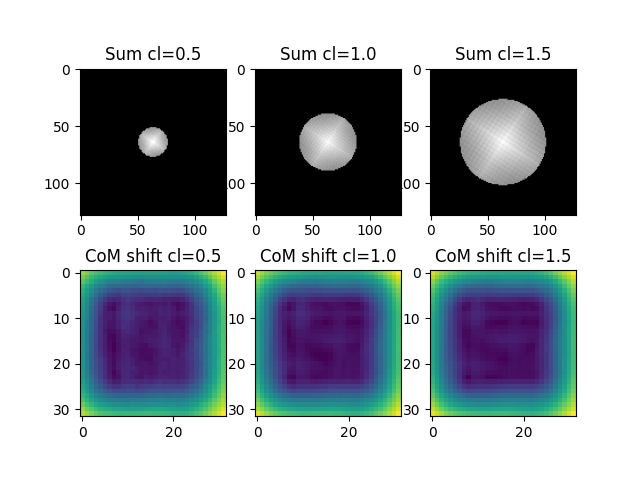

In [9]:
fig, axs = plt.subplots(2, 3)

com_r = {}
com_udf = CoMUDF.with_params()
for i, (cl, ds) in enumerate(datasets.items()):
    sum_res, com_res = ctx.run_udf(ds, [SumUDF(), com_udf])
    com_r[cl] = com_res
    axs[0, i].imshow(sum_res["intensity"].data, cmap="gray")
    axs[0, i].set_title(f"Sum cl={cl}")
for i, (cl, ds) in enumerate(datasets.items()):
    axs[1, i].imshow(com_r[cl]["magnitude"].data)
    axs[1, i].set_title(f"CoM shift cl={cl}")

We can see that there is mose descan error at longer camera lengths, meaning we have an error dependent on the slope of the rays leaving the descanner.

## 3 - Determine parameters ignoring descan error

Even in the presence of descan error, we can reconstruct a single dataset to determine the scan geometry and defocus. The result will be distorted, but should still be sharp when the right parameters are found. We start from a scan step which is know approximately, but with no knowledge of the scan step or defocus value:

In [10]:
# guess_params = copy.deepcopy(params)
# cl = 1.0
# guess_params["camera_length"] = cl
# guess_params["semi_conv"] = semi_conv_guess
# guess_params["defocus"] = 0.
# guess_params["scan_step"] = np.asarray(guess_params["scan_step"]) * np.random.uniform(0.8, 1.2)
# guess_params["scan_rotation"] = 0.
# interactive_window(ctx, datasets[cl], guess_params)


Now we have an estimate of the CoM shift for each dataset we can compute a point virtual detector image with the most basic kind of error compensation: Simply fitting a 3x3 affine transform matrix to the pixel shifts, and using that to registrate each disk back to the centre of the detector. The drawback is we must compute a new affine transform for each camera length, and we do not correct for astigmatism in the disks.

## 4 - Descan error fit

With these parameters determined and more certainty on the input coordinate scan coordinates, we can then solve simultaneously on the three datasets to determine the descan error matrix that describes the microscope experiment. This descan error matrix will determine the propagation matrix of the microscope that describes the descan error dependance on camera length, and enable us to correct for astigmatism in the disks also.

In [14]:
params['defocus']

0.01

In [18]:
scan_coords = []
det_coords = []
b_vals = []
for camera_length, ds in datasets.items():
    crossover_z = jnp.zeros((1))
    ScanGrid = comp.ScanGrid(
        z=jnp.array(params['defocus']),
        scan_step=params['scan_step'],
        scan_shape=ds.shape.nav.to_tuple(),
        scan_rotation=params['scan_rotation'],
    )
    scan_coords.append(ScanGrid.coords)
    Detector = comp.Detector(
        z=jnp.array(camera_length),
        det_shape=ds.shape.sig.to_tuple(),
        det_pixel_size=params['det_px_size'],
        flip_y=params['flip_y'],
    )
    yx_px_det = com_r[camera_length]["raw_com"].data.reshape(-1, 2)
    det_coords.append(np.stack(Detector.pixels_to_metres(yx_px_det.T), axis=1))
    b_vals.append(camera_length - params['defocus'])

bvals = np.concatenate(
    tuple(np.full((c.shape[0],), b) for b, c in zip(b_vals, scan_coords))
)
scan_coords = np.concatenate(scan_coords, axis=0)
det_coords = np.concatenate(det_coords, axis=0)
bvals.shape

(3072,)

In [ ]:
def descan_model(vars, pxo_pxi, pxo_pyi, p):
    spx, spy, B = vars
    xout = pxo
    return sxin * (Adx_dpos + B * Cdx_dslope) + yin * (Ady_dpos + B * Cdy_dslope)


# Take only N random samples from the data
num_samples = 10000
indices = np.random.choice(bvals.size, num_samples, replace=False)

popt_x, pcov_x = curve_fit(
    descan_model,
    (scan_coords[:, 0][indices], scan_coords[:, 1][indices], bvals[indices]),
    det_coords[:, 0][indices],
    p0=np.zeros(4),
)
Axx, Cxx, Axy, Cxy = popt_x

popt_y, pcov_y = curve_fit(
    descan_model,
    (scan_coords[:, 0][indices], scan_coords[:, 1][indices], bvals[indices]),
    det_coords[:, 1][indices],
    p0=np.zeros(4),
)
Ayx, Cyx, Ayy, Cyy = popt_y

ValueError: Cannot take a larger sample than population when 'replace=False'

In [20]:
print("\nFit ABCD Values (with 5-sigma error):")
print(f"Axx_dpos = {Axx:.2f} ± {5 * np.sqrt(pcov_x[0, 0]):.2e}")
print(f"Axy_dpos = {Axy:.2f} ± {5 * np.sqrt(pcov_x[2, 2]):.2e}")
print(f"Ayx_dpos = {Ayx:.2f} ± {5 * np.sqrt(pcov_y[0, 0]):.2e}")
print(f"Ayy_dpos = {Ayy:.2f} ± {5 * np.sqrt(pcov_y[2, 2]):.2e}")
print(f"Cxx_dslope = {Cxx:.2f} ± {5 * np.sqrt(pcov_x[1, 1]):.2e}")
print(f"Cxy_dslope = {Cxy:.2f} ± {5 * np.sqrt(pcov_x[3, 3]):.2e}")
print(f"Cyx_dslope = {Cyx:.2f} ± {5 * np.sqrt(pcov_y[1, 1]):.2e}")
print(f"Cyy_dslope = {Cyy:.2f} ± {5 * np.sqrt(pcov_y[3, 3]):.2e}")

Axx, Ayy, Cxx, Cyy = (
    8,
    6,
    -20,
    -16,
)  # Normal Descan Error terms Axx, Ayy, Cxx, Cyy in transfer matrix
Axy, Ayx, Cxy, Cyx = (
    12,
    -14,
    -12,
    20,
)  # Cross Descan Error terms Axy, Ayx, Cxy, Cyx in transfer matrix


Fit ABCD Values (with 5-sigma error):


NameError: name 'Axx' is not defined

In [ ]:
raise

## Show final result

In [ ]:
cl = 1.0
ds = datasets[cl]
# initial_guesses
model_parameters = {
    "semi_conv": semiconv,
    "defocus": defocus,  # Distance from the crossover to the sample
    "camera_length": cl,  # Distance from the sample to the detector
    "scan_shape": ds.shape.nav,  # YX!
    "det_shape": ds.shape.sig,  # YX!
    "scan_step": scan_step,  # YX!
    "det_px_size": det_px_size,  # YX!
    "scan_rotation": scan_rotation,
    "descan_error": np.asarray([Axx - 1, Axy, Ayx, Ayy - 1, Cxx, Cxy, Cyx, Cyy]),
    "flip_y": flip_y,
    "px_shifts": None,  # YX!
}
interactive_window(ctx, ds, model_parameters)